In [48]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import plotly.express as px
from itertools import product
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

# Save Results

## Load mlflow runs

In [49]:
db_port = 5001
db_name = 'recursive_clustering'
w = 'clust9'
# url = f'postgresql://{w}.ceremade.dauphine.lan:{db_port}/{db_name}'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
results_dir = Path('/home/bbelucci/code/recursive_clustering/results/processed_results')
results_dir.mkdir(parents=True, exist_ok=True)

In [31]:
experiment_names

['Default',
 'blob_experiment',
 'hpo_classif_experiment',
 'hpo_openml_experiment',
 'hpo_gaussian_experiment',
 'hpo_openml_final',
 'outlier_hc',
 'time_hc',
 'hpo_n_clusters',
 'hpo_classif_huge',
 'test',
 'gaussian_random_KMeans_calinski_harabasz_score',
 'gaussian_random_RecursiveClustering_calinski_harabasz_score',
 'gaussian_random_RecursiveClustering_silhouette',
 'gaussian_random_KMeans_silhouette']

In [32]:
experiments_names = [
    'hpo_gaussian_experiment',
]

In [33]:
params_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'n_centers',
    'distance',
    'seed_unified',
]

In [34]:
latest_metrics_columns = [
    'fit_model_return_elapsed_time',
    'max_memory_used',
    'n_clusters_',
    'rand_score',
    'adjusted_rand',
    'mutual_info',
    'adjusted_mutual_info',
    'normalized_mutual_info',
    'homogeneity_completeness_v_measure',
    'silhouette',
    'best_n_clusters_',
    'best_rand_score',
    'best_adjusted_rand',
    'best_mutual_info',
    'best_adjusted_mutual_info',
    'best_normalized_mutual_info',
    'best_homogeneity_completeness_v_measure',
    'best_silhouette',
]

In [35]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'parent_run_id',
    'best_child_run_id',
]

In [36]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [37]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)

In [38]:
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['parent_run_id'].isna()]

In [39]:
df_runs_raw_parents

key,status,start_time,end_time,distance,model_nickname,n_centers,n_features,n_samples,seed_unified,adjusted_mutual_info,...,fit_model_return_elapsed_time,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
00d72239d3d442cd92f198f39d180401,FINISHED,1737417765262,1737417866344,5.0,AffinityPropagation,5,1000,100,1,0.052337,...,42.255706,349.024,0.217890,24.0,0.092974,0.776361,-0.003887,9cf265ec6b0042ef9f98cf013f584ca6,NaN,False
00f5ede9d1d3460580e6ec22c4e2010d,FINISHED,1737370049357,1737370292888,100.0,HDBSCAN,5,100,1000,3,1.000000,...,78.176391,525.568,1.609438,5.0,1.000000,1.000000,0.859418,d120a6fecc2b4a8ba19678a96dd5caac,NaN,False
01435afcd6fb481b966e4c91c37a7929,FINISHED,1737370014728,1737370465275,30.0,WardAgglomerativeClustering,5,100,1000,5,0.769025,...,77.608350,516.412,1.609438,14.0,0.769601,0.880928,0.002602,6305eb488d744b84ba80edcdf108f443,NaN,False
0146e2f7bcde414c89652abf655baa8c,FINISHED,1737417830446,1737418201869,30.0,WardAgglomerativeClustering,5,1000,1000,0,0.771151,...,323.548075,549.276,1.609438,14.0,0.771724,0.882679,0.000147,5dd2c7a93fb844a3a83ac6609128ffa0,NaN,False
017138d5d2e345ad9ae7558e02e6ba68,FINISHED,1737370025437,1737402901255,3.0,SpectralSubspaceRandomization,5,100,1000,6,0.139336,...,8154.440541,16105.284,0.341715,30.0,0.143582,0.790122,-0.009516,0bc87d170a7c4c219e57450cfd8abfb4,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fee797330cdd473db838f3b87d418f78,FINISHED,1737370077969,1737400234118,5.0,AffinityPropagation,5,100,1000,9,0.275843,...,2560.302090,1432.916,0.953065,162.0,0.290882,0.802651,-0.010245,9deb4c2278d440e6bfe9327a8420f8ff,NaN,False
fef66750ca9c4469a783662c957b3eb8,FINISHED,1737417802981,1737419121875,10.0,WardAgglomerativeClustering,5,1000,1000,3,0.712519,...,316.750402,576.268,1.492547,14.0,0.713236,0.873611,-0.000762,40fffeb15abe4c52a0ccd56613b9ca5d,NaN,False
fefa886e7787483a994a7774c47b50ce,FINISHED,1737417746438,1737423279869,3.0,AffinityPropagation,5,1000,1000,4,0.007942,...,968.355978,1359.220,0.079953,133.0,0.025368,0.793431,-0.027983,e4b33d8ac5dc4a1084e91ffa92a96675,NaN,False


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [40]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'n_centers',
    'distance',
    'seed_unified',
]
df_runs_parents = df_runs_raw_parents.dropna(axis=0, how='all', subset=['best_adjusted_rand']).copy()
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]

no_run_time = 4*3600
df_runs_timed_out = df_runs_raw.copy()
df_runs_timed_out = df_runs_timed_out.loc[df_runs_timed_out.EXCEPTION == 'FunctionTimedOut']
df_runs_timed_out = df_runs_timed_out.loc[(~df_runs_timed_out.duplicated(non_duplicate_columns))]
df_runs_timed_out['fit_model_return_elapsed_time'] = no_run_time
df_runs = pd.concat([df_runs, df_runs_timed_out])

status = 'FAILED'
no_run_memory = 2*120000
raised_exception = True
EXCEPTION = 'NoRun'
start_time = time.time() * 1000
end_time = time.time() * 1000

# IRFLLRR do not run with n_samples > 14427
model_nickname = 'IRFLLRR'
n_samples = ['14427', '50000']
n_features = ['100', '347', '1202', '4163', '14427', '50000']
combinations = product(n_samples, n_features)
df_cat = []
indexes = []
for n_sample, n_feature in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

# KMeansProj do not run with (14427,14427), (14427,50000), (50000,14427), (50000,50000)
model_nickname = 'KMeansProj'
n_samples = ['14427', '50000']
n_features = ['14427', '50000']
combinations = product(n_samples, n_features)
df_cat = []
indexes = []
for n_sample, n_feature in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

# HDBSCAN do not run with (14427,14427), (14427,50000), and n_samples = 50000 n_features > 347
model_nickname = 'HDBSCAN'
n_samples = ['50000']
n_features = ['347', '1202', '4163', '14427', '50000']
combinations = list(product(n_samples, n_features))
combinations += [('14427', '14427'), ('14427', '50000')]
df_cat = []
indexes = []
for n_sample, n_feature in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

# SpectralSubspaceRandomization do not run with n_samples > 50000
model_nickname = 'SpectralSubspaceRandomization'
n_samples = ['50000']
n_features = ['100', '347', '1202', '4163', '14427', '50000']
combinations = list(product(n_samples, n_features))
df_cat = []
indexes = []
for n_sample, n_feature in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

# ensure no duplicates
df_runs = df_runs.loc[(~df_runs.duplicated(non_duplicate_columns))]

# Missing

In [41]:
df_runs_parents['model_nickname'].unique().tolist()

['AffinityPropagation',
 'HDBSCAN',
 'WardAgglomerativeClustering',
 'SpectralSubspaceRandomization',
 'RecursiveClustering',
 'KMeans',
 'DBSCAN']

In [42]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'distance',
    'n_centers',
    'seed_unified',
]

In [43]:
n_samples = ['100', '1000']
n_features = ['1000']
distances = ['3.0', '5.0', '10.0', '30.0', '100.0']
n_centers = ['5']
seed_unified = [f'{i}' for i in range(5)]
model_nickname = [
    'AffinityPropagation',
    'HDBSCAN',
    'WardAgglomerativeClustering',
    'SpectralSubspaceRandomization',
    'RecursiveClustering',
    'KMeans',
    'DBSCAN'
]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, distances, n_centers, seed_unified]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [44]:
df_missing

,model_nickname,n_samples,n_features,distance,n_centers,seed_unified


In [45]:
n_samples = ['1000']
n_features = ['1000']
distances = ['100.0']
n_centers = ['5', '10', '20', '50', '100']
seed_unified = [f'{i}' for i in range(5)]
model_nickname = [
    # 'AffinityPropagation',
    # 'HDBSCAN',
    # 'WardAgglomerativeClustering',
    # 'SpectralSubspaceRandomization',
    'RecursiveClustering',
    # 'KMeans',
    # 'DBSCAN'
]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, distances, n_centers, seed_unified]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [46]:
df_missing

,model_nickname,n_samples,n_features,distance,n_centers,seed_unified


# Get common combinations

In [17]:
model_nickname = [
    'AffinityPropagation',
    'HDBSCAN',
    'WardAgglomerativeClustering',
    'SpectralSubspaceRandomization',
    'RecursiveClustering',
    'KMeans',
    'DBSCAN'
]
df = df_runs_parents.copy()
df = df.loc[df['model_nickname'].isin(model_nickname)]
column = 'model_nickname'
combination_columns = [
    'n_samples',
    'n_features',
    'distance',
    'n_centers',
    'seed_unified',
]
common_combinations = get_common_combinations(df, column, combination_columns)

In [18]:
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [19]:
df_common['n_samples'] = df_common['n_samples'].astype(int)
df_common['n_features'] = df_common['n_features'].astype(int)
df_common['distance'] = df_common['distance'].astype(float)
df_common['n_centers'] = df_common['n_centers'].astype(float)
df_common['seed_unified'] = df_common['seed_unified'].astype(int)

In [20]:
df_common

key,status,start_time,end_time,distance,model_nickname,n_centers,n_features,n_samples,seed_unified,adjusted_mutual_info,...,fit_model_return_elapsed_time,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
00d72239d3d442cd92f198f39d180401,FINISHED,1737417765262,1737417866344,5.0,AffinityPropagation,5.0,1000,100,1,0.052337,...,42.255706,349.024,0.217890,24.0,0.092974,0.776361,-0.003887,9cf265ec6b0042ef9f98cf013f584ca6,NaN,False
00f5ede9d1d3460580e6ec22c4e2010d,FINISHED,1737370049357,1737370292888,100.0,HDBSCAN,5.0,100,1000,3,1.000000,...,78.176391,525.568,1.609438,5.0,1.000000,1.000000,0.859418,d120a6fecc2b4a8ba19678a96dd5caac,NaN,False
01435afcd6fb481b966e4c91c37a7929,FINISHED,1737370014728,1737370465275,30.0,WardAgglomerativeClustering,5.0,100,1000,5,0.769025,...,77.608350,516.412,1.609438,14.0,0.769601,0.880928,0.002602,6305eb488d744b84ba80edcdf108f443,NaN,False
0146e2f7bcde414c89652abf655baa8c,FINISHED,1737417830446,1737418201869,30.0,WardAgglomerativeClustering,5.0,1000,1000,0,0.771151,...,323.548075,549.276,1.609438,14.0,0.771724,0.882679,0.000147,5dd2c7a93fb844a3a83ac6609128ffa0,NaN,False
017138d5d2e345ad9ae7558e02e6ba68,FINISHED,1737370025437,1737402901255,3.0,SpectralSubspaceRandomization,5.0,100,1000,6,0.139336,...,8154.440541,16105.284,0.341715,30.0,0.143582,0.790122,-0.009516,0bc87d170a7c4c219e57450cfd8abfb4,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fee797330cdd473db838f3b87d418f78,FINISHED,1737370077969,1737400234118,5.0,AffinityPropagation,5.0,100,1000,9,0.275843,...,2560.302090,1432.916,0.953065,162.0,0.290882,0.802651,-0.010245,9deb4c2278d440e6bfe9327a8420f8ff,NaN,False
fef66750ca9c4469a783662c957b3eb8,FINISHED,1737417802981,1737419121875,10.0,WardAgglomerativeClustering,5.0,1000,1000,3,0.712519,...,316.750402,576.268,1.492547,14.0,0.713236,0.873611,-0.000762,40fffeb15abe4c52a0ccd56613b9ca5d,NaN,False
fefa886e7787483a994a7774c47b50ce,FINISHED,1737417746438,1737423279869,3.0,AffinityPropagation,5.0,1000,1000,4,0.007942,...,968.355978,1359.220,0.079953,133.0,0.025368,0.793431,-0.027983,e4b33d8ac5dc4a1084e91ffa92a96675,NaN,False


In [24]:
df_common

key,status,start_time,end_time,distance,model_nickname,n_centers,n_features,n_samples,seed_unified,adjusted_mutual_info,...,fit_model_return_elapsed_time,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
00d72239d3d442cd92f198f39d180401,FINISHED,1737417765262,1737417866344,5.0,AffinityPropagation,5.0,1000,100,1,0.052337,...,42.255706,349.024,0.217890,24.0,0.092974,0.776361,-0.003887,9cf265ec6b0042ef9f98cf013f584ca6,NaN,False
00f5ede9d1d3460580e6ec22c4e2010d,FINISHED,1737370049357,1737370292888,100.0,HDBSCAN,5.0,100,1000,3,1.000000,...,78.176391,525.568,1.609438,5.0,1.000000,1.000000,0.859418,d120a6fecc2b4a8ba19678a96dd5caac,NaN,False
01435afcd6fb481b966e4c91c37a7929,FINISHED,1737370014728,1737370465275,30.0,WardAgglomerativeClustering,5.0,100,1000,5,0.769025,...,77.608350,516.412,1.609438,14.0,0.769601,0.880928,0.002602,6305eb488d744b84ba80edcdf108f443,NaN,False
0146e2f7bcde414c89652abf655baa8c,FINISHED,1737417830446,1737418201869,30.0,WardAgglomerativeClustering,5.0,1000,1000,0,0.771151,...,323.548075,549.276,1.609438,14.0,0.771724,0.882679,0.000147,5dd2c7a93fb844a3a83ac6609128ffa0,NaN,False
017138d5d2e345ad9ae7558e02e6ba68,FINISHED,1737370025437,1737402901255,3.0,SpectralSubspaceRandomization,5.0,100,1000,6,0.139336,...,8154.440541,16105.284,0.341715,30.0,0.143582,0.790122,-0.009516,0bc87d170a7c4c219e57450cfd8abfb4,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fee797330cdd473db838f3b87d418f78,FINISHED,1737370077969,1737400234118,5.0,AffinityPropagation,5.0,100,1000,9,0.275843,...,2560.302090,1432.916,0.953065,162.0,0.290882,0.802651,-0.010245,9deb4c2278d440e6bfe9327a8420f8ff,NaN,False
fef66750ca9c4469a783662c957b3eb8,FINISHED,1737417802981,1737419121875,10.0,WardAgglomerativeClustering,5.0,1000,1000,3,0.712519,...,316.750402,576.268,1.492547,14.0,0.713236,0.873611,-0.000762,40fffeb15abe4c52a0ccd56613b9ca5d,NaN,False
fefa886e7787483a994a7774c47b50ce,FINISHED,1737417746438,1737423279869,3.0,AffinityPropagation,5.0,1000,1000,4,0.007942,...,968.355978,1359.220,0.079953,133.0,0.025368,0.793431,-0.027983,e4b33d8ac5dc4a1084e91ffa92a96675,NaN,False


# Plots

In [27]:
df_common['model_nickname'].unique().tolist()

['AffinityPropagation',
 'HDBSCAN',
 'WardAgglomerativeClustering',
 'SpectralSubspaceRandomization',
 'RecursiveClustering',
 'KMeans',
 'DBSCAN']

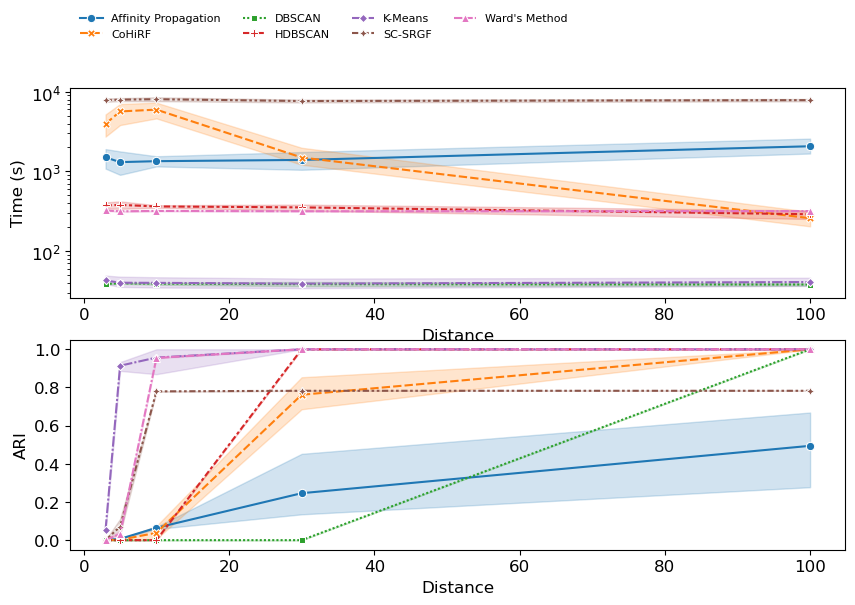

In [28]:
df = df_common.copy()
n_features = 1000
n_samples = 1000
pct_random_features = 0.0
distance = 30
hpo_metric = 'silhouette'

models_names = {
    'RecursiveClustering': 'CoHiRF',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    # 'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    # 'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
    'AverageAgglomerativeClustering': 'Average Agglomerative',
    'CompleteAgglomerativeClustering': 'Complete Agglomerative',
    'SingleAgglomerativeClustering': 'Single Agglomerative',
    'IRFLLRR': 'IRFLLRR',
    # 'Proclus': 'Proclus',
    # 'Clique': 'Clique',
    'KMeansProj': 'Projective K-Means',
}
df['n_samples'] = df['n_samples'].astype(int)
df['n_features'] = df['n_features'].astype(int)
df['distance'] = df['distance'].astype(float)
# df = df.loc[df['hpo_metric']==hpo_metric]
# df = df.loc[df['pct_random_features']==pct_random_features]
# df = df.loc[df['distance'].isin([70,80,100,150,200])]
# df = df.loc[~df['class_sep'].isin([10, 20])]
# df = df.loc[df['model_nickname'].isin(models_names.keys())]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model', 'distance': 'Distance', 'pct_random_features': '% Random Features', 'best_adjusted_rand' : 'ARI'})
plt.style.use('default')
with mpl.rc_context(rc={
    # 'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'figure.figsize': (10, 6),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 12,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    fig, axs = plt.subplots(2, 1)
    axs = axs.flatten()
    df_plot = df.copy()
    df_plot = df_plot.loc[df_plot['Number of features']==n_features]
    df_plot = df_plot.loc[df_plot['Number of samples']==n_samples]
    ax = sns.lineplot(data=df_plot, x='Distance', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[0])
    ax.legend().set_visible(False)
    ax.set_yscale('log')
    ax2 = sns.lineplot(data=df_plot, x='Distance', y='ARI', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[1])
    ax2.legend().set_visible(False)
    ax.legend(title=None, fontsize=8, bbox_to_anchor=(0.0, 1.4), ncols=4)
    # plt.savefig(results_dir / f'gaussian_n-samples{n_samples}_n-features{n_features}_with_time.pdf')
    plt.show()

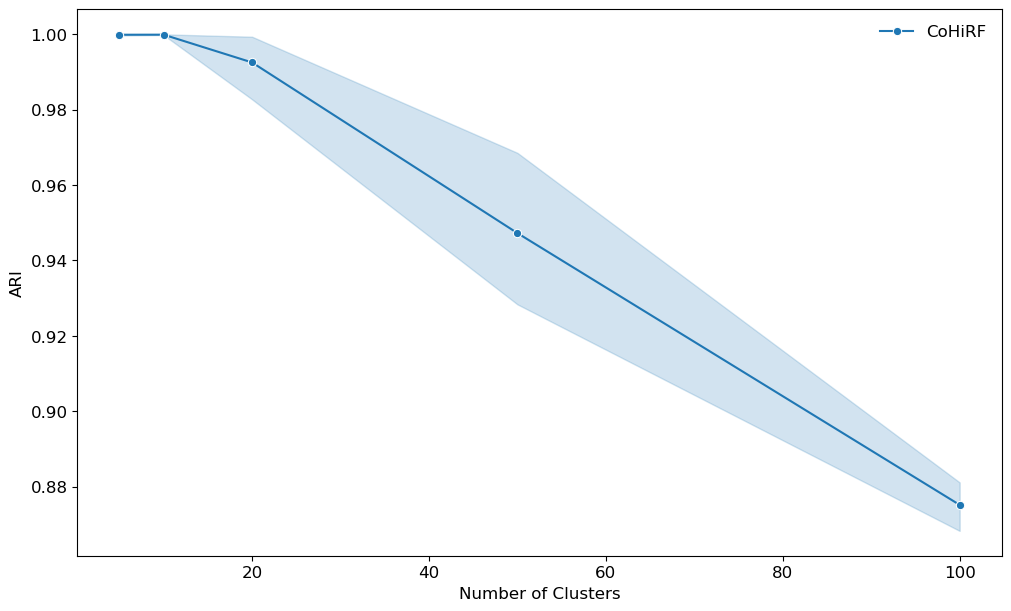

In [50]:
n_samples = 1000
n_features = 1000
distance = 100
models_names = {
    'RecursiveClustering': 'CoHiRF',
}
df = df_runs_parents.copy()
df['n_samples'] = df['n_samples'].astype(int)
df['n_features'] = df['n_features'].astype(int)
df['distance'] = df['distance'].astype(float)
df['n_centers'] = df['n_centers'].astype(int)
df = df.loc[df['model_nickname'].isin(models_names.keys())]
df = df.loc[df['n_samples'] == n_samples]
df = df.loc[df['n_features'] == n_features]
df = df.loc[df['distance'] == distance]
df = df.replace({'model_nickname': models_names})
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_informative_features': 'Number of Informative Features', 'model_nickname': 'Model', 'distance': 'Distance', 'pct_random_features': '% Random Features', 'best_adjusted_rand' : 'ARI', 'n_random_features': 'Number of Random Features', 'n_centers': 'Number of Clusters'})
plt.style.use('default')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'figure.figsize': (10, 6),
    # 'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 12,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    # fig, axs = plt.subplots(1, 1)
    # axs = axs.flatten()
    df_plot = df.copy()
    # ax = sns.lineplot(data=df_plot, x='Number of Random Features', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci', ax=axs[0])
    # ax.legend().set_visible(False)
    # ax.set_yscale('log')
    ax2 = sns.lineplot(data=df_plot, x='Number of Clusters', y='ARI', hue='Model', style='Model', markers=True, errorbar='ci')
    # ax2.legend().set_visible(False)
    # ax.legend(title=None, fontsize=8, bbox_to_anchor=(0.0, 1.4), ncols=4)
    ax2.legend(title=None)
    plt.savefig(results_dir / f'gaussian_centers_n-samples{n_samples}_n_features{n_features}_distance{distance}.pdf')
    plt.show()

# Debug and explore

In [61]:
df = df_runs_raw_parents.copy()
df = df.loc[df['model_nickname'] == 'SpectralClustering']
df = df.loc[df['n_samples'] == '10000']
df = df.loc[df['n_features'] == '100']
df = df.loc[df['best_adjusted_rand'].isna()]

In [62]:
df

key,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features,n_informative,n_random,n_samples,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
030506f367eb4de3ba20854815b5204e,RUNNING,1736933684597,NaN,50.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0a9621d4c0b94f71b8b3381c6fb5c007,RUNNING,1736933682412,NaN,50.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4283d0ec6c2a44609380a30ba9ad84b7,RUNNING,1736933676990,NaN,100.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86f54c66e3a24ae3abd719993b9e8e8f,RUNNING,1736933680295,NaN,10.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d40e99f19313471b849c6a89d5714ec3,RUNNING,1736933677012,NaN,10.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f2472d2177ee4224888a3f9221aa27f8,RUNNING,1736933676833,NaN,100.0,SpectralClustering,5,100,2,16,10000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
parent_run_ids = list(df.index)

In [39]:
parent_run_ids

['19a02df7b5aa4cf7afa3bd89746701e6',
 '49cd3a57c8c445888338d601be88e165',
 '4ca1b086e9d54eb69b43c9d2a9f61751',
 '8ebecbdcf2534dbdb37fab56eb920877',
 'bc25dc49e69644d9b4ea7d47831c0db5',
 'c08e53cf4d534e67904e72ae35794d0e']

In [40]:
df = df_runs_raw.copy()
df = df.loc[df['parent_run_id'].isin(parent_run_ids)]

In [41]:
child_run_ids = list(df.index)

In [42]:
runs_to_delete = parent_run_ids + child_run_ids

In [43]:
runs_to_delete

['19a02df7b5aa4cf7afa3bd89746701e6',
 '49cd3a57c8c445888338d601be88e165',
 '4ca1b086e9d54eb69b43c9d2a9f61751',
 '8ebecbdcf2534dbdb37fab56eb920877',
 'bc25dc49e69644d9b4ea7d47831c0db5',
 'c08e53cf4d534e67904e72ae35794d0e',
 '1d4c759e165b4267af1d71e2dadb662e',
 '4731af3b49f94df79ed9c06cb61e5da9',
 '667f300899fe4b998d839e3958dedbd0',
 '8f9e6a95c8bd4f838fcb3085a3927482',
 'c7b04bdc92654f8da5f28f7a0474de79',
 'e97b7dd9f4c94acb95ad1b389c91aa3d']

In [44]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [45]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    